# **Speech to Emotion Recognition**
James Knee, Tyler Nguyen, Varsha Singh, Anish Sinha, Nathan Strahs


---

### Task ###
Our task is to use a deep learning architecture to identify the underlying emotion given some English speaking audio, formally known as Speech to Emotion Recognition (SER). Identifying emotions from speech is hard enough for people, and it requires careful analysis over time. Emotional conveyance is also subjective; different speakers articulate emotions differently, implying variations in pitch, intensity, rhythm, and cadence. This task is also challenging due to the complexity of raw audio signals, so the data will require significant amounts of preprocessing. In the end, we would like our model to differentiate between anger, disgust, fear, happiness, sadness, and neutrality.


---

# Architecture Overview

1. **Preprocessing**
      - Normalize audio volume
      - Convert audio to time-frequency representations like Spectograms
2. **Feature Extraction via ResNet**
      - Feed spectogram into Residual Network
      - Retain extracted features by removing final classification layer in ResNet
3. **Temporal Modeling via Transformer Encoder**
      - Pass ResNet output to transformer and capture long-range dependencies and sequential relationships in the audio
4. **Classification Layer**
      - Apply a softmax layer to classify the output into one of six emotion categories: anger, disgust, fear, happiness, sadness, neutrality.

Alternative Model: State Space Model (SSM) such as Mamba

[insert diagram here]

# Datasets

Below are the datasets we will use for our Speech Emotion Recognition project:

- **CREMA-D (Crowd-Sourced Emotional Multimodal Actors Dataset)**
  - **Description**: An audio-visual dataset comprising 7,442 clips from 91 actors (48 male, 43 female) aged between 20 and 74, representing diverse ethnic backgrounds. Actors vocalized 12 sentences expressing six emotions: anger, disgust, fear, happiness, neutral, and sadness. Each clip has multiple ratings for audio-only, visual-only, and audio-visual presentations.
  - **Link**: https://www.kaggle.com/datasets/ejlok1/cremad

- **RAVDESS (Ryerson Audio-Visual Database of Emotional Speech and Song)**
  - **Description**: Comprises 7,356 files from 24 professional actors (12 male, 12 female) speaking two lexically-matched statements in a neutral North American accent. Speech includes eight emotions: neutral, calm, happy, sad, angry, fearful, surprise, and disgust, each at two intensity levels. Available in audio-only, video-only, and audio-visual formats.
  - **Link**: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio

- **Berlin Emotional Database**
  - **Description**: Contains 535 utterances from ten actors (five male, five female) expressing seven emotions: anger, boredom, disgust, fear, happiness, sadness, and neutral. Recorded at 48kHz and downsampled to 16kHz.
  - **Link**: http://emodb.bilderbar.info/
  - **Kaggle Link**: https://www.kaggle.com/datasets/piyushagni5/berlin-database-of-emotional-speech-emodb


# Preprocessing Data

In [1]:
import sys
print(sys.executable)

/projectnb/ec523/projects/teamSER/miniconda/envs/mamba-env/bin/python


In [2]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display
import seaborn as sns

import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchaudio
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts


import random
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import matplotlib.pyplot

from mamba_ssm import Mamba

2025-04-30 17:05:20.430113: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-30 17:05:20.450136: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746047120.466884  488231 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746047120.471983  488231 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746047120.484104  488231 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
! nvidia-smi

Wed Apr 30 17:05:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.124.06             Driver Version: 570.124.06     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-16GB           On  |   00000000:18:00.0 Off |                    0 |
| N/A   45C    P0             46W /  300W |       4MiB /  16384MiB |      0%   E. Process |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
#necessary variables, assuming root directory is /projectnb/ec523/projects/teamSER folder
cremad_path = '/projectnb/ec523/projects/teamSER/cremad/'
ravdess_path = '/projectnb/ec523/projects/teamSER/ravdess/audio_speech_actors_01-24/'
tess_path = '/projectnb/ec523/projects/teamSER/tess/TESS Toronto emotional speech set data/'
savee_path = '/projectnb/ec523/projects/teamSER/savee/ALL/'

training_split = 0.8
testing_split = 0.2
batch_size = 32
sampling_rate = 22000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Load Data

In [5]:
# Put the cremad directory in a list
cremad = os.listdir(cremad_path)
# Make a list for emotion labels and a list for path to audio files
emotions = []
paths = []
# Loop through all the files and extract the emotion label and path
for file in cremad:
    # Extract the emotion label from the file name
    emotion = file.split('_')[2]
    if emotion == 'SAD':
        emotion = 'sadness'
    elif emotion == 'ANG':
        emotion = 'anger'
    elif emotion == 'DIS':
        emotion = 'disgust'
    elif emotion == 'FEA':
        emotion = 'fear'
    elif emotion == 'HAP':
        emotion = 'happiness'
    elif emotion == 'NEU':
        emotion = 'neutral'
    elif emotion == 'SUR':
        emotion = 'surprise'
    else:
        emotion = 'Unknown'
    # Extract the path
    path = cremad_path + file
    # Append the emotion and path to their lists
    emotions.append(emotion)
    paths.append(path)
# Create a dataframe from the lists
cremad_df = pd.DataFrame(emotions, columns=['Emotion'])
cremad_df['Path'] = paths
# Inspect the dataframe
cremad_df.head()

,Emotion,Path
0,anger,/projectnb/ec523/projects/teamSER/cremad/1080_...
1,neutral,/projectnb/ec523/projects/teamSER/cremad/1069_...
2,disgust,/projectnb/ec523/projects/teamSER/cremad/1055_...
3,anger,/projectnb/ec523/projects/teamSER/cremad/1060_...
4,anger,/projectnb/ec523/projects/teamSER/cremad/1004_...


In [6]:
# Put the ravdess directory in a list
ravdess = os.listdir(ravdess_path)
# Make a list for emotion labels and a list for path to audio files
emotions = []
paths = []
# Loop through all the actor directories in audio_speech_actors_01-24
for dir in ravdess:
    # Loop through all the files in each directory
    for file in os.listdir(ravdess_path + dir):
        # Extract the emotion label from the file name
        emotion = file.split('-')[2]
        if emotion == '01':
            emotion = 'neutral'
        elif emotion == '02':
            emotion = 'calm'
        elif emotion == '03':
            emotion = 'happiness'
        elif emotion == '04':
            emotion = 'sadness'
        elif emotion == '05':
            emotion = 'anger'
        elif emotion == '06':
            emotion = 'fear'
        elif emotion == '07':
            emotion = 'disgust'
        elif emotion == '08':
            emotion = 'surprise'
        else:
            emotion = 'Unknown'
        # Extract the path
        path = ravdess_path + dir + '/' + file
        # Append the emotion and path to their lists
        emotions.append(emotion)
        paths.append(path)
# Create a dataframe from the lists
ravdess_df = pd.DataFrame(emotions, columns=['Emotion'])
ravdess_df['Path'] = paths
# Inspect the dataframe
ravdess_df.head()

,Emotion,Path
0,neutral,/projectnb/ec523/projects/teamSER/ravdess/audi...
1,happiness,/projectnb/ec523/projects/teamSER/ravdess/audi...
2,disgust,/projectnb/ec523/projects/teamSER/ravdess/audi...
3,sadness,/projectnb/ec523/projects/teamSER/ravdess/audi...
4,sadness,/projectnb/ec523/projects/teamSER/ravdess/audi...


In [7]:
# Put the tess directory in a list
tess = os.listdir(tess_path)
# Make a list for emotion labels and a list for path to audio files
emotions = []
paths = []
# Loop through all the audio file directories
for dir in tess:
    # Loop through all the files in each directory
    for file in os.listdir(tess_path + dir):
        # Extract the emotion label from the file name
        emotion = file.split('.')[0]
        emotion = emotion.split('_')[2]
        if emotion == 'ps':
            emotion = 'surprise'
        elif emotion == 'sad':
            emotion = 'sadness'
        elif emotion == 'disgust':
            emotion = 'disgust'
        elif emotion == 'angry':
            emotion = 'anger'
        elif emotion == 'happy':
            emotion = 'happiness'
        elif emotion == 'neutral':
            emotion = 'neutral'
        elif emotion == 'fear':
            emotion = 'fear'
        else:
            emotion = 'Unknown'
        # Extract the path
        path = tess_path + dir + '/' + file
        # Append the emotion and path to their lists
        emotions.append(emotion)
        paths.append(path)
# Create a dataframe from the lists
tess_df = pd.DataFrame(emotions, columns=['Emotion'])
tess_df['Path'] = paths
# Inspect the dataframe
tess_df.head()

,Emotion,Path
0,disgust,/projectnb/ec523/projects/teamSER/tess/TESS To...
1,disgust,/projectnb/ec523/projects/teamSER/tess/TESS To...
2,disgust,/projectnb/ec523/projects/teamSER/tess/TESS To...
3,disgust,/projectnb/ec523/projects/teamSER/tess/TESS To...
4,disgust,/projectnb/ec523/projects/teamSER/tess/TESS To...


In [8]:
# Put the savee directory in a list
savee = os.listdir(savee_path)
# Make a list for emotion labels and a list for path to audio files
emotions = []
paths = []
# Loop through all the files in the ALL directory
for file in savee:
    # Separate the wav file name from the emotion label
    emotion = file.split('.')[0]
    # Extract the emotion label from the file name
    emotion = emotion.split('_')[1]
    # Exclude the numbers from the emotion label
    emotion = emotion[:-2]
    if emotion == 'a':
        emotion = 'anger'
    elif emotion == 'd':
        emotion = 'disgust'
    elif emotion == 'f':
        emotion = 'fear'
    elif emotion == 'h':
        emotion = 'happiness'
    elif emotion == 'n':
        emotion = 'neutral'
    elif emotion == 'sa':
        emotion = 'sadness'
    elif emotion == 'su':
        emotion = 'surprise'
    else:
        emotion = 'Unknown'
    # Extract the path
    path = savee_path + file
    # Append the emotion and path to their lists
    emotions.append(emotion)
    paths.append(path)
# Create a dataframe from the lists
savee_df = pd.DataFrame(emotions, columns=['Emotion'])
savee_df['Path'] = paths
# Inspect the dataframe
savee_df.head()

,Emotion,Path
0,neutral,/projectnb/ec523/projects/teamSER/savee/ALL/KL...
1,surprise,/projectnb/ec523/projects/teamSER/savee/ALL/KL...
2,neutral,/projectnb/ec523/projects/teamSER/savee/ALL/KL...
3,anger,/projectnb/ec523/projects/teamSER/savee/ALL/KL...
4,sadness,/projectnb/ec523/projects/teamSER/savee/ALL/DC...


# create dataframe

In [9]:
# Create a dataframe that contains all the emotion labels and paths from all the datasets
df = pd.concat([cremad_df, ravdess_df, tess_df, savee_df], axis=0)
# Reset the index
df = df.reset_index(drop=True)
df = df[~df['Emotion'].isin(['calm', 'surprise'])]
df['Emotion'].value_counts()

Emotion
anger        1923
disgust      1923
fear         1923
happiness    1923
sadness      1923
neutral      1703
Name: count, dtype: int64

# enumerating emotions

In [10]:
encoder = LabelEncoder()
df['Emotion'] = encoder.fit_transform(df['Emotion'])
# Make sure the encoding worked
df['Emotion'].value_counts()

Emotion
0    1923
1    1923
2    1923
3    1923
5    1923
4    1703
Name: count, dtype: int64

# Processing Audio

In [11]:
# Create a function that takes an audio file path and returns the mel spectrogram
# as an image, and converts the image into a numpy array
def process_audio(path):
    ''' 
    Load the audio file, convert the audio file into a mel spectrogram,
    return the mel spectrogram as an image, and convert the image into a numpy array
    '''
    # Load the audio file and set the sampling rate to 22000
    audio, sr = librosa.load(path, sr=sampling_rate, duration=4, mono=True)
    
    # pad the audio files that are less than 4 seconds with zeros at the end
    if len(audio) < 4 * sr:
        audio = np.pad(audio, pad_width=(0, 4 * sr - len(audio)), mode='constant')
        
    # Convert the audio file into a mel spectrogram
    signal = librosa.feature.melspectrogram(y = audio, sr=sr, n_mels=128)
    
    # Convert the spectrogram from amplitude squared to decibels
    signal = librosa.power_to_db(signal, ref=np.min)    
    image = torch.tensor(signal, dtype=torch.float32)
    
    # normalize + offset if zero
    image = (image - image.mean()) / (image.std() + 1e-6)
    
    # Return the image
    return image

# extracting mel-frequency cepstral coefficients
def extract_mfcc(path):
    ''' 
    Load the audio file, convert the audio file into MFCCs and return the MFCCs
    '''
    # Load the audio file and set the sampling rate to 22000
    audio, sr = librosa.load(path, sr=sampling_rate, duration=4, mono=True)
    
    # Pad the audio files that are less than 4 seconds with zeros at the end
    if len(audio) < 4 * sr:
        audio = np.pad(audio, pad_width=(0, 4 * sr - len(audio)), mode='constant')

    # extract mfcc features and normalize
    signal = librosa.feature.mfcc(y = audio, sr=sr, n_mfcc=128)
    signal = (signal - signal.mean()) / (signal.std() + 1e-6)

    # RETURN A TENSOR OF FLOAT32
    return torch.tensor(signal, dtype=torch.float32)

# combine all feature and label data into one set
def collate_fn(batch):
    # get spectrograms and labels for all in batch
    spectrograms, labels = zip(*batch)

    #pad spectrograms to match longest
    max_length = max(spec.shape[1] for spec in spectrograms)
    spectrograms_padded = [torch.nn.functional.pad(spec, (0, max_length - spec.shape[1])) for spec in spectrograms]

    # Convert list to tensor
    spectrograms_padded = torch.stack(spectrograms_padded)
    labels = torch.tensor(labels, dtype=torch.long)
    return spectrograms_padded, labels


class AudioDataset(Dataset):
    def __init__(self, dataframe):
        # store the dataframe and its labels
        self.df = dataframe
        self.labels = [torch.tensor(label, dtype=torch.long) for label in self.df['Emotion']]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row['Path']
        label = row['Emotion']

        # Process audio
        #spectrogram = process_audio(path)
        spectrogram = extract_mfcc(path)

        # If needed, you can add transforms here (like normalization)

        return spectrogram, torch.tensor(label, dtype=torch.long)

# Load and separate dataset

In [12]:
dataset = AudioDataset(df)

# Get indices and labels for stratification
all_indices = list(range(len(dataset)))
all_labels = dataset.labels  # These are already mapped to integers

# Split into train+val and test
#trainval_idx, test_idx = train_test_split(
#    all_indices, test_size=0.15, stratify=all_labels, random_state=42)

# Now split trainval into train and val
train_idx, val_idx = train_test_split(
    all_indices, test_size=testing_split, stratify=all_labels, random_state=42)

# Create subsets
train_set = torch.utils.data.Subset(dataset, train_idx)
val_set = torch.utils.data.Subset(dataset, val_idx)
test_set = torch.utils.data.Subset(dataset, val_idx)

# Enable augmentation only on training set
train_set.dataset.transform = True
val_set.dataset.transform = False
test_set.dataset.transform = False

# Dataloaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

# Training Code

In [13]:
# training model and displaying training statistics
def train_model(model, optimizer, criterion, scheduler, device, train_loader, val_loader, num_epochs=30, patience=7):
    # send model to the device (cuda)
    model.to(device)
    best_val_acc = 0.0
    best_model_state = None
    best_epoch = 0

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        # set model for training
        model.train()
        running_loss = 0.0
        total = 0
        correct = 0

        for inputs, labels in train_loader:
            # send data to device
            inputs, labels = inputs.to(device), labels.to(device)

            # backwards pass
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # same as your original
            optimizer.step()
            if scheduler is not None:
                scheduler.step(epoch + total / len(train_loader))  # cosine scheduler behavior
                
            # aggregate loss in pass
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # report values for loss
        epoch_loss = running_loss / total
        train_acc = 100 * correct / total
        val_acc = test_model(model, val_loader, device)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            best_model_state = model.state_dict()
        elif epoch - best_epoch >= patience:
            print("Early stopping triggered.")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    print(f"\nBest Validation Accuracy: {best_val_acc:.2f}% at Epoch {best_epoch+1}")
    return model, history

# testing model function
def test_model(model, test_loader, device):
    # send model to device and set to evaluation mode (no learning)
    model.to(device)
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return acc

# currently a wrapper for test_model
def train_accuracy_model(model, train_loader, device):
    # (Not strictly needed anymore since train acc is inside train loop already)
    return test_model(model, train_loader, device)

# plotting function for training history
def plot_history(history, model_name="Model"):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure()
    plt.plot(epochs, history['train_loss'], label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{model_name} - Training Loss')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{model_name} - Train vs Val Accuracy')
    plt.legend()
    plt.show()

In [41]:
# save weights
torch.save(trained_base.state_dict(), '/projectnb/ec523/students/varsingh/mambabase_weights.pth')

# Base mamba (72%) with multi-head gated attention

In [14]:
class MultiHeadGatedPooling(nn.Module):
    def __init__(self, d_model, heads=4):
        super().__init__()
        self.heads = heads
        self.att = nn.Linear(d_model, heads)
        self.gate = nn.Linear(d_model, heads)

    def forward(self, x):  # (B, T, D)
        B, T, D = x.shape
        attn = self.att(x)              # (B, T, H)
        gate = torch.sigmoid(self.gate(x))  # (B, T, H)
        scores = torch.softmax(attn, dim=1)  # (B, T, H)
        x = x.unsqueeze(-1) * gate.unsqueeze(2)  # (B, T, D, H)
        pooled = (x * scores.unsqueeze(2)).sum(dim=1)  # (B, D, H)
        return pooled.mean(dim=2)  # (B, D)


class BaseMambaV8(nn.Module):  
    def __init__(self, num_classes=6, d_model=256):
        super().__init__()
        self.input_proj = nn.Linear(128, d_model)
        
        self.mamba1 = Mamba(
            d_model=d_model,
            d_state=32,
            d_conv=4,
            expand=3
        )
        self.mamba2 = Mamba(
            d_model=d_model,
            d_state=32,
            d_conv=4,
            expand=2
        )
        
        self.attention_pool = MultiHeadGatedPooling(d_model, heads=4)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.classifier = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(0.4)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, d_model * 2),
            nn.GELU(),
            nn.Dropout(0.4),
            nn.Linear(d_model * 2, num_classes)
        )
        
    def forward(self, x):
        # flatten all but batch dimension (B, 1, F, T) -> (B, F*T))
        x = x.transpose(1,2)
        x = self.input_proj(x)  

        x = self.norm1(x)
        x = self.mamba1(x) + x
        x = F.gelu(x)
        x = self.dropout(x)
        
        x = self.norm2(x)
        x = self.mamba2(x) + x
        x = F.gelu(x)
        x = self.dropout(x)
        
        x_res = x.mean(dim=1)  # optional residual shortcut over time
        x = self.attention_pool(x)
        x = x + x_res          # residual add
        return self.mlp_head(x)

In [ ]:
# training for base-mamba
model_baseV8 = BaseMambaV8(num_classes = 6)

# set optimizer and criterion
optimizer = optim.AdamW(model_baseV8.parameters(), lr=5e-4, weight_decay=1e-2)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# train the model
trained_baseV8, history_baseV8 = train_model(model_baseV8, optimizer, criterion, scheduler, device, train_loader, val_loader, num_epochs=30)

Epoch 1/30 | Train Loss: 1.5707 | Train Acc: 38.07% | Val Acc: 46.64%
Epoch 2/30 | Train Loss: 1.3481 | Train Acc: 51.54% | Val Acc: 47.70%
Epoch 3/30 | Train Loss: 1.2319 | Train Acc: 57.53% | Val Acc: 57.42%
Epoch 4/30 | Train Loss: 1.1638 | Train Acc: 61.69% | Val Acc: 63.16%
Epoch 5/30 | Train Loss: 1.1078 | Train Acc: 64.65% | Val Acc: 60.03%
Epoch 6/30 | Train Loss: 1.0432 | Train Acc: 68.73% | Val Acc: 63.38%
Epoch 7/30 | Train Loss: 0.9960 | Train Acc: 71.05% | Val Acc: 62.23%
Epoch 8/30 | Train Loss: 0.9465 | Train Acc: 74.01% | Val Acc: 66.56%
Epoch 9/30 | Train Loss: 0.8999 | Train Acc: 76.91% | Val Acc: 67.67%
Epoch 10/30 | Train Loss: 0.8532 | Train Acc: 79.27% | Val Acc: 66.92%
Epoch 11/30 | Train Loss: 0.7991 | Train Acc: 81.94% | Val Acc: 67.98%
Epoch 12/30 | Train Loss: 0.7449 | Train Acc: 84.98% | Val Acc: 69.79%
Epoch 13/30 | Train Loss: 0.7005 | Train Acc: 87.21% | Val Acc: 69.88%
Epoch 14/30 | Train Loss: 0.6593 | Train Acc: 89.42% | Val Acc: 71.11%
Epoch 15/30 | T

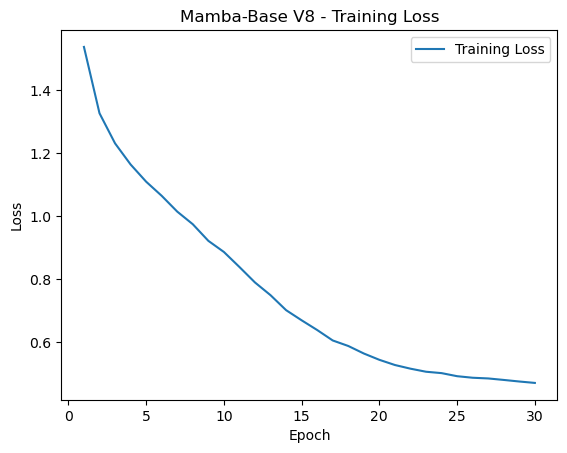

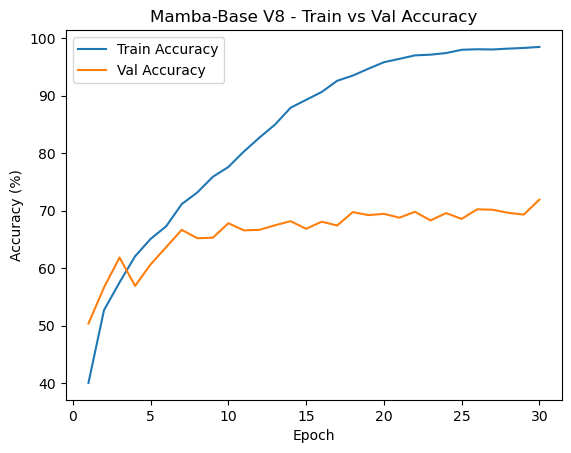

In [43]:
# plot the results
plot_history(history_baseV8, model_name="Mamba-Base V8")
# save weights
torch.save(trained_baseV8.state_dict(), '/projectnb/ec523/students/varsingh/mambabase_v8_weights.pth')